# Comparison between two time series 
Using PROMETHEE method, comparing times series by applying the first steps of the method (until aggregated preference).

From this it is needed to use a 3rd time series in order to be able to apply a ranking system to these time series

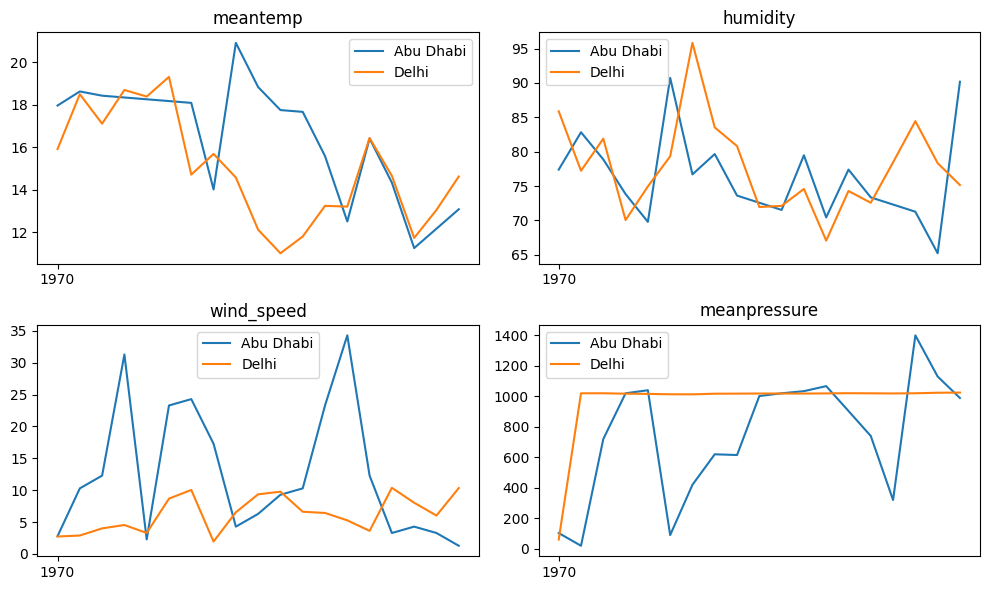

In [2]:
# Read data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

data1 = pd.read_csv('../data/City/DailyAbuDhabiClimateTest.csv')
data2 = pd.read_csv('../data/City/DailyDelhiClimateTest.csv')


def plot_time_series(data1, data2, city1, city2):
    """ 
    The time series being multivariate with columns
    date, meantemp, humidy, wind_speed, meanpressure
    
    Plot each of the columns against the date for both cities
    """
    fig, ax = plt.subplots(2, 2, figsize=(10, 6))

    for i, column in enumerate(data1.columns[1:]):
        ax[i//2, i % 2].plot(data1['date'], data1[column], label=city1)
        ax[i//2, i % 2].plot(data2['date'], data2[column], label=city2)
        ax[i//2, i % 2].set_title(column)
        ax[i//2, i % 2].xaxis.set_major_locator(mdates.YearLocator())
        ax[i//2, i % 2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax[i//2, i % 2].legend()

    plt.tight_layout()
    plt.show()


plot_time_series(data1, data2, 'Abu Dhabi', 'Delhi')



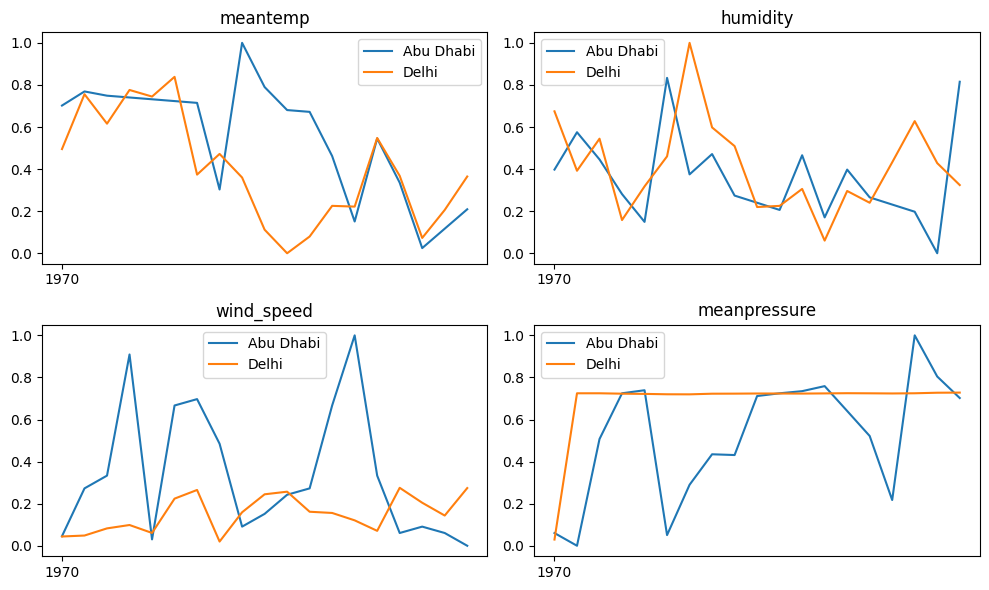

In [3]:
def normalize_columns(data1, data2):
    """
    Normalize each columns of the dataframes data1 and data2 independently except the date column 
    such that the values are in [-1, 1]
    """
    data1_norm = data1.copy()
    data2_norm = data2.copy()
    for column in data1.columns[1:]:
        # Use the mean and standard deviation of the column of both dataframes to normalize
        mean = (data1[column].mean() + data2[column].mean()) / 2
        std = (data1[column].std() + data2[column].std()) / 2

        data1_norm[column] = (data1[column] - mean) / std
        data2_norm[column] = (data2[column] - mean) / std
    return data1_norm, data2_norm

def scale_columns(data1, data2):
    """
    Normalize each columns of the dataframes data1 and data2 independently except the date column 
    such that the values are in [-1, 1]
    """
    data1_norm = data1.copy()
    data2_norm = data2.copy()
    for column in data1.columns[1:]:
        # Normalized per column using all the data
        min_val = min(data1[column].min(), data2[column].min())
        max_val = max(data1[column].max(), data2[column].max())

        data1_norm[column] = (data1[column] - min_val) / (max_val - min_val)
        data2_norm[column] = (data2[column] - min_val) / (max_val - min_val)
    return data1_norm, data2_norm


# data1_norm, data2_norm = normalize_columns(data1, data2)
data1_scaled, data2_scaled = scale_columns(data1, data2)

plot_time_series(data1_scaled, data2_scaled, 'Abu Dhabi', 'Delhi')



## Application of Promethee
Now that the data has been normalized, let's try to apply the PROMETHEE method to compare those two times series

This is divided in multiple steps:
1. Compute the difference between the two times series column per column $d_i(a,b)$ having $i$ the criteria and $a,b$ the two times series data1 and data2
2. Compute $\pi^{c}(a,b)$ for each criteria $i$ $$\pi_c(a,b) = \sum_{i=1}^k w_i\cdot P(d_i(a,b))$$

### Step 1 : compute difference between time series

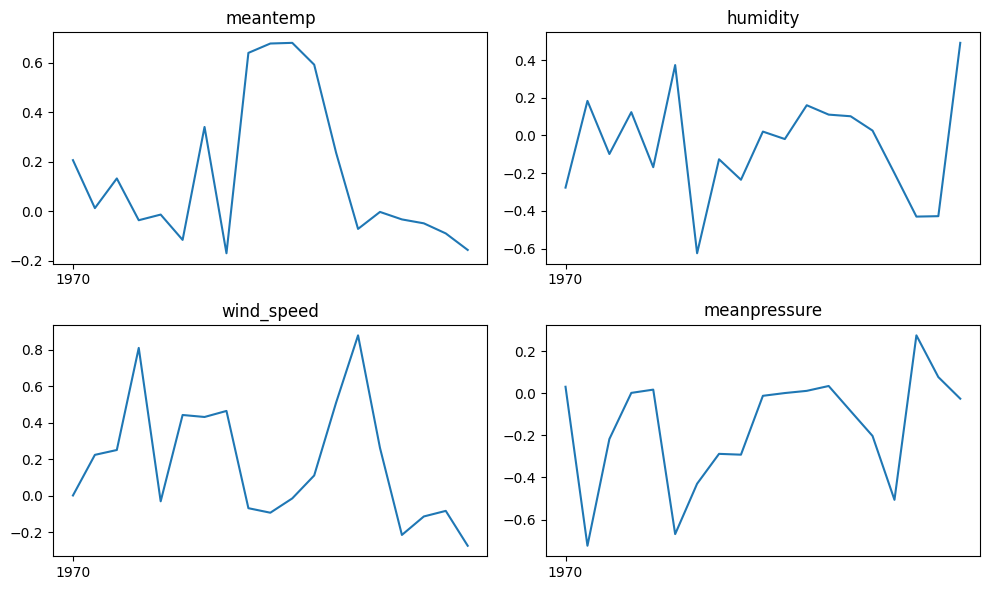

In [4]:
# Step 1: compute the difference between the two cities for each column
data_diff = data1_scaled.copy()
for column in data1_scaled.columns[1:]:
    data_diff[column] = data1_scaled[column] - data2_scaled[column]

# Step 2: plot the difference
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
for i, column in enumerate(data1_scaled.columns[1:]):
    ax[i//2, i % 2].plot(data1['date'], data_diff[column])
    ax[i//2, i % 2].set_title(column)
    ax[i//2, i % 2].xaxis.set_major_locator(mdates.YearLocator())
    ax[i//2, i % 2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

### Step 2: Compute $\Pi_i(a,b)$

C:\Users\raphu\AppData\Local\Temp\ipykernel_47696\3210388374.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  d_ab[column][i] = (d_ab[column][i] - Q[current_criteria_index]) / (P[current_criteria_index] - Q[current_criteria_index])
C:\Us

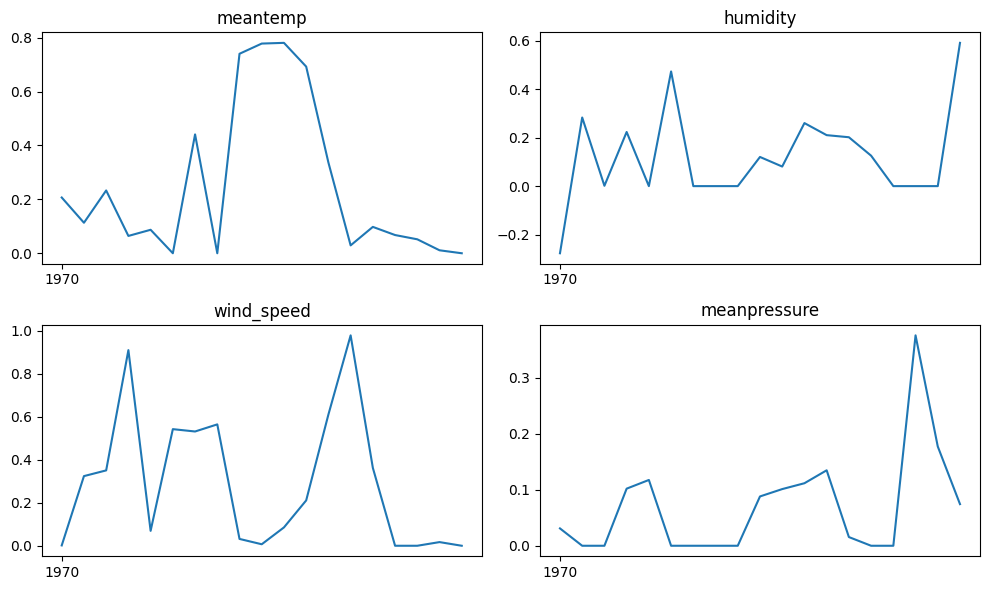

In [ ]:
P = [0.9, 0.9, 0.9, 0.9] # Preference parameters
Q = [-0.1, -0.1, -0.1, -0.1] # Indifference parameters
W = [0.25, 0.25, 0.25, 0.25] # Weights

def F_ab_linear(d_ab):
    current_criteria_index = 0
    for column in d_ab.columns[1:]:
        for i in range(1, len(d_ab)):
            if d_ab[column][i] <= Q[current_criteria_index]:
                d_ab[column][i] = 0
            elif d_ab[column][i] > P[current_criteria_index]:
                d_ab[column][i] = 1
            else:
                d_ab[column][i] = (d_ab[column][i] - Q[current_criteria_index]) / (P[current_criteria_index] - Q[current_criteria_index])
        current_criteria_index += 1
    return d_ab

F_d_ab = F_ab_linear(data_diff)


# Step 3: plot the decision matrix
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
for i, column in enumerate(data_diff.columns[1:]):
    ax[i//2, i % 2].plot(data1['date'], F_d_ab[column])
    ax[i//2, i % 2].set_title(column)
    ax[i//2, i % 2].xaxis.set_major_locator(mdates.YearLocator())
    ax[i//2, i % 2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

In [6]:
print(F_d_ab)

print(F_d_ab.shape[0])

          date  meantemp  humidity  wind_speed  meanpressure
0   2017-01-01  0.206836 -0.276923    0.001515      0.030939
1   2017-01-02  0.113146  0.283037    0.324147      0.000000
2   2017-01-03  0.232973  0.001381    0.350747      0.000000
3   2017-01-04  0.064286  0.223337    0.910494      0.101856
4   2017-01-05  0.087097  0.000000    0.069433      0.117339
5   2017-01-06  0.000000  0.473039    0.542712      0.000000
6   2017-01-07  0.440966  0.000000    0.531807      0.000000
7   2017-01-08  0.000000  0.000000    0.564888      0.000000
8   2017-01-09  0.740040  0.000000    0.031771      0.000000
9   2017-01-10  0.777890  0.120276    0.006976      0.087951
10  2017-01-11  0.780543  0.080750    0.085427      0.101075
11  2017-01-12  0.692428  0.260025    0.211060      0.111516
12  2017-01-13  0.336583  0.210268    0.610788      0.134588
13  2017-01-14  0.029229  0.201624    0.979252      0.015522
14  2017-01-15  0.097809  0.125562    0.362451      0.000000
15  2017-01-16  0.067572

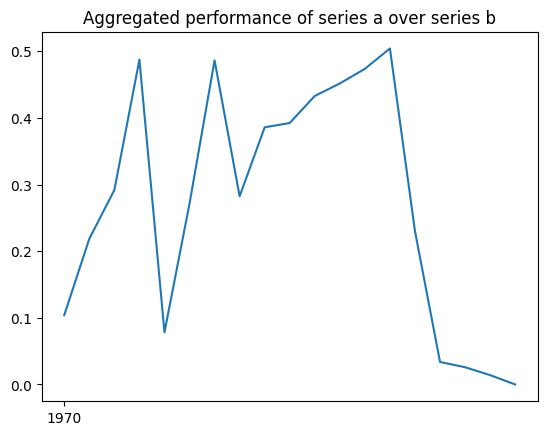

In [8]:
def PI_ab(F_d_ab, W):
    """ 
    Compute Aggregated Performance Index for a over b
    """
    # Remove the date column from F_d_ab
    F_d_ab = F_d_ab.drop(columns='date')
    PI_ab = []
    for i in range(F_d_ab.shape[0]):
        PI_ab.append(F_d_ab.iloc[i].dot(W))

    # Transform the list to a pandas series
    # with the date as the index
    PI_ab = pd.Series(PI_ab)
    PI_ab.index = data1['date']
    return PI_ab

W = [0.5, 0, 0.5, 0] # Weights

PI_d_ab = PI_ab(F_d_ab, W)

# Step 4: plot the performance index
plt.plot(data1['date'], PI_d_ab)
plt.title('Aggregated performance of series a over series b')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()
